In [3]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [4]:
asset_type = "all"

metrics = {
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = f"median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [5]:
def drop_invalid_rows(df):
    return df[~df[metric_pct_chg].isna()].reset_index(drop=True)

In [6]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

all_years = list(range(start_year, eval_end_year + 1))
train_years = list(range(start_year, eval_start_year))
eval_years = list(range(eval_start_year, eval_end_year + 1))

yearly_dataframes = {
    f"{year}": drop_invalid_rows(df[df["year"] == year]) for year in all_years
}

cumulative_yearly_dataframes = {
    f"{year}": drop_invalid_rows(df[df["year"].between(start_year, year)])
    for year in all_years
}

# Set up extra dataframes for evaluation
for i in range(1, years_ahead + 1):
    yearly_dataframes[f"{eval_end_year + i}"] = (
        yearly_dataframes[f"{eval_end_year}"][["area", "area_code", "asset_type"]]
        .drop_duplicates()
        .assign(year=eval_end_year + i)
    )
    yearly_dataframes[f"{eval_end_year + i}"]["yearly_price_growth"] = np.nan
    yearly_dataframes[f"{eval_end_year + i}"][metric_pct_chg] = np.nan
    yearly_dataframes[f"{eval_end_year + i}"][normalized_metric_pct_chg] = np.nan


combined_eval_df = drop_invalid_rows(df[df["year"] >= eval_start_year])

# Finally
df = df.fillna(0)

In [7]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [8]:
BATCH_SIZE = 256

In [9]:
yearly_datasets = {
    f"{year}": JapanRETimeSeriesDataset(
        df,
        cumulative_yearly_dataframes[f"{year}"],
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        weight_column="weight",
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead,
    )
    for year in all_years
}

yearly_dataloaders = {
    f"{year}": DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
    )
    for year, train_dataset in yearly_datasets.items()
}

combined_eval_dataset = JapanRETimeSeriesDataset(
    df,
    combined_eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
)

combined_eval_dataloader = DataLoader(
    combined_eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [11]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0.1
enc_dropout = 0


In [12]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs_per_year = 10

In [13]:
# Incremental training and evaluation (Eval years = [2021, 2022])
progress_bar = None
save_predictions = True

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

for year in all_years:
    print(f"-----------------")
    print(f" Year: {year}")
    print(f"-----------------")

    model = TimeSeriesTransformerModel(
        n_features=n_features,
        d_model=d_model,
        nhead=nhead,
        d_hid=d_hid,
        nlayers=nlayers,
        dropout=dropout,
        enc_dropout=enc_dropout,
        device=device,
    )
    model = model.to(device)

    train_dataloader = yearly_dataloaders[f"{year}"]
    num_training_steps = num_epochs_per_year * len(train_dataloader)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    lr_scheduler = get_scheduler(
        "linear",  # constant
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(num_epochs_per_year):
        train_loss, train_r2_score = train_weighted(
            model,
            train_dataloader,
            optimizer,
            lr_scheduler,
            progress_bar,
            device=device,
        )
        train_losses.append(train_loss)
        train_r2_scores.append(train_r2_score)

        eval_loss, eval_r2_score = evaluate_weighted(
            model, combined_eval_dataloader, device=device
        )
        eval_losses.append(eval_loss)
        eval_r2_scores.append(eval_r2_score)

        print(f" Epoch: {epoch}")
        print(f" Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
        print(f" Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")
        # 2021 and 2022 years will have overlap, so ignore those
    
    if save_predictions:
        # Even predicts for 2023 and 2024
        # Predict returns n years ahead
        output_dataset_name = f"{dataset_name}_{year + years_ahead}"
        model_output_data_path = model_output_data_paths[output_dataset_name]
        prediction_df = yearly_dataframes[f"{year + years_ahead}"]

        prediction_df["predicted_normalized_return"] = predict_returns(
            model,
            df,
            prediction_df,
            feature_columns,
            device=device,
        )

        prediction_df[
            [
                "year",
                "area_code",
                "asset_type",
                "predicted_normalized_return",
                "yearly_price_growth",
                metric_pct_chg,
                normalized_metric_pct_chg,
            ]
        ].to_csv(model_output_data_path, index=False)

-----------------
 Year: 2007
-----------------
 Epoch: 0
 Train Loss: 9.1751, Eval Loss: 16.2813
 Train R^2: -0.1163, Eval R^2: -0.8658
 Epoch: 1
 Train Loss: 21.8714, Eval Loss: 8.9284
 Train R^2: -1.1424, Eval R^2: -0.1332
 Epoch: 2
 Train Loss: 10.4024, Eval Loss: 8.2344
 Train R^2: -0.1548, Eval R^2: -0.1029
 Epoch: 3
 Train Loss: 8.1119, Eval Loss: 10.5004
 Train R^2: 0.0106, Eval R^2: -0.3616
 Epoch: 4
 Train Loss: 10.4848, Eval Loss: 10.9091
 Train R^2: -0.2170, Eval R^2: -0.4022
 Epoch: 5
 Train Loss: 10.5071, Eval Loss: 10.0742
 Train R^2: -0.2144, Eval R^2: -0.3043
 Epoch: 6
 Train Loss: 9.4482, Eval Loss: 9.1404
 Train R^2: -0.1231, Eval R^2: -0.1961
 Epoch: 7
 Train Loss: 8.5488, Eval Loss: 8.4995
 Train R^2: -0.0303, Eval R^2: -0.1214
 Epoch: 8
 Train Loss: 7.7174, Eval Loss: 8.1593
 Train R^2: 0.0475, Eval R^2: -0.0812
 Epoch: 9
 Train Loss: 7.6380, Eval Loss: 8.0256
 Train R^2: 0.0570, Eval R^2: -0.0651
-----------------
 Year: 2008
-----------------
 Epoch: 0
 Train Lo

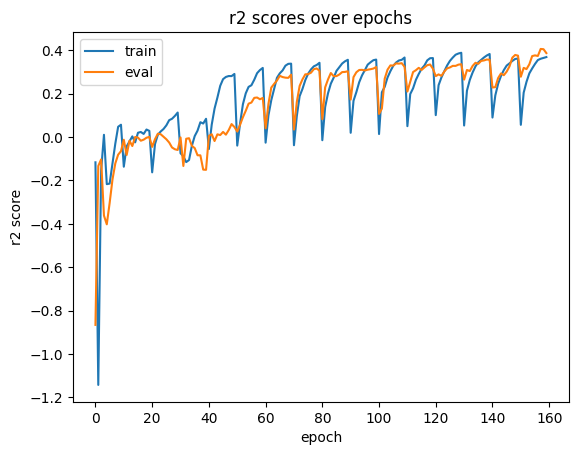

In [14]:
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

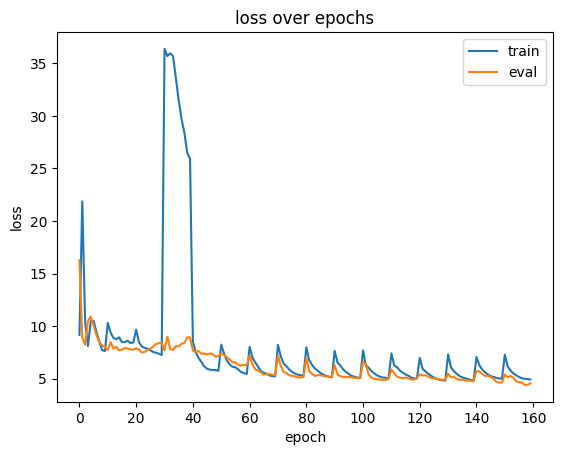

In [16]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

In [ ]:
investment_start_year = 2012
investment_end_year = 2020
investment_eval_end_year = 2022

asset_type = "building"

asset_count = 20
shorting_enabled = True
cash, assets, liabilities = 1000, {}, {}

# Reinvest all earnings: cash * ( 1 / 20 )

for year in range(investment_start_year, investment_eval_end_year):
    current_year_df = pd.read_csv(model_output_data_paths[f"{dataset_name}_{year}"])
    current_year_df = current_year_df[current_year_df["asset_type"] == "building"]
    current_year_df = current_year_df.set_index('area_code')

    assets = {
        area_code: value * ( 1 + current_year_df.loc[area_code, "yearly_price_growth"] )
        for area_code, value in assets.items()
    } 
    liabilities = {
        area_code: value * ( 1 + current_year_df.loc[area_code, "yearly_price_growth"] )
        for area_code, value in liabilities.items()
    }

    nav = sum(assets.values() - liabilities.values()) + cash

    if year <= investment_end_year:
        # Close Positions
        cash, assets, liabilities = nav, {}, {}

        # Rebalance
        prediction_year_df = pd.read_csv(model_output_data_paths[f"{dataset_name}_{year + years_ahead}"])
        prediction_year_df = prediction_year_df[prediction_year_df["asset_type"] == "building"]
        prediction_year_df = prediction_year_df.set_index('area_code')

        top_areas = prediction_year_df.nlargest(asset_count, "predicted_normalized_return").index
        bottom_areas = prediction_year_df.nsmallest(asset_count, "predicted_normalized_return").index

        # Invest
        assets = {
            area_code: cash * ( 1 / asset_count )
            for area_code in top_areas
        }

        # Short
        if shorting_enabled:
            liabilities = {
                area_code: cash * ( 1 / asset_count )
                for area_code in bottom_areas
            }

        cash -= sum(assets.values())
        cash += sum(liabilities.values())
        



In [ ]:
# When I'm predicting 2022, I want a model trained only on 2020 and before
